In [1]:
from sklearn import datasets
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import mpl_toolkits.mplot3d
import numpy as np
import matplotlib.pyplot as plt

iris = datasets.load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names

In [2]:
"""
Вопрос 1: условия на внешний цикл оптимизации - если что можно еще делать перебор гиперпараметров h или ядра. 
Если вопрос касается нейронных сетей: что еще делали, когда сетка переобучалась? Больше данных/регуляризации или другой подход


1) есть большая ошибка на трейне - это underfitting, нужно: менять модель, либо увеличивать тренировочный датасет, либо менять подход.
2) есть большая ошибка на валидационных данных (малая на трейне) - это overfitting - модель слишком хорошо приспособилась к тренировочным данным, поэтому не переваривает валидационные. Нужно: больше данных, больше регуляризации (усложнение алгоритма), либо другой подход.
3) большая ошибка на test (на трейн и вал. малая) - то, как в реальности будет работать модель; такая ошибка - результат того, что train и test отличаются (из разных датасетов). Значит нужно больше данных, похожих на test.
4) малая ошибка на всех данных - победа!

Вопрос 2: демонстрация того, что при шаффле обучающей выборки заряды поменяются
Вопрос 3: Недостатки метрических методов: не обязательно нужно хранить целую выборку. В мпф не нужно хранить всю обуч. выборку
Вопрос 4: Метод потенциальных функций - похоже надо поменять алгоритм и сделать без запоминания всей выборки. 

"""

'\nВопрос 1: условия на внешний цикл оптимизации - если что можно еще делать перебор гиперпараметров h или ядра. \nЕсли вопрос касается нейронных сетей: что еще делали, когда сетка переобучалась? Больше данных/регуляризации или другой подход\n\n\n1) есть большая ошибка на трейне - это underfitting, нужно: менять модель, либо увеличивать тренировочный датасет, либо менять подход.\n2) есть большая ошибка на валидационных данных (малая на трейне) - это overfitting - модель слишком хорошо приспособилась к тренировочным данным, поэтому не переваривает валидационные. Нужно: больше данных, больше регуляризации (усложнение алгоритма), либо другой подход.\n3) большая ошибка на test (на трейн и вал. малая) - то, как в реальности будет работать модель; такая ошибка - результат того, что train и test отличаются (из разных датасетов). Значит нужно больше данных, похожих на test.\n4) малая ошибка на всех данных - победа!\n\nВопрос 2: демонстрация того, что при шаффле обучающей выборки заряды поменяю

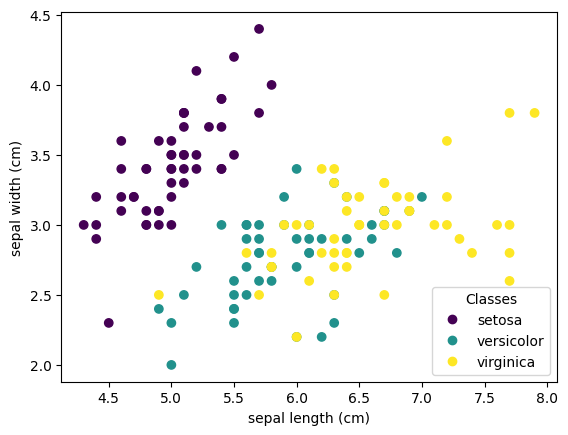

In [3]:
_, ax = plt.subplots()
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
) #TODO: добавить визуализацию для всех 4-х признаков

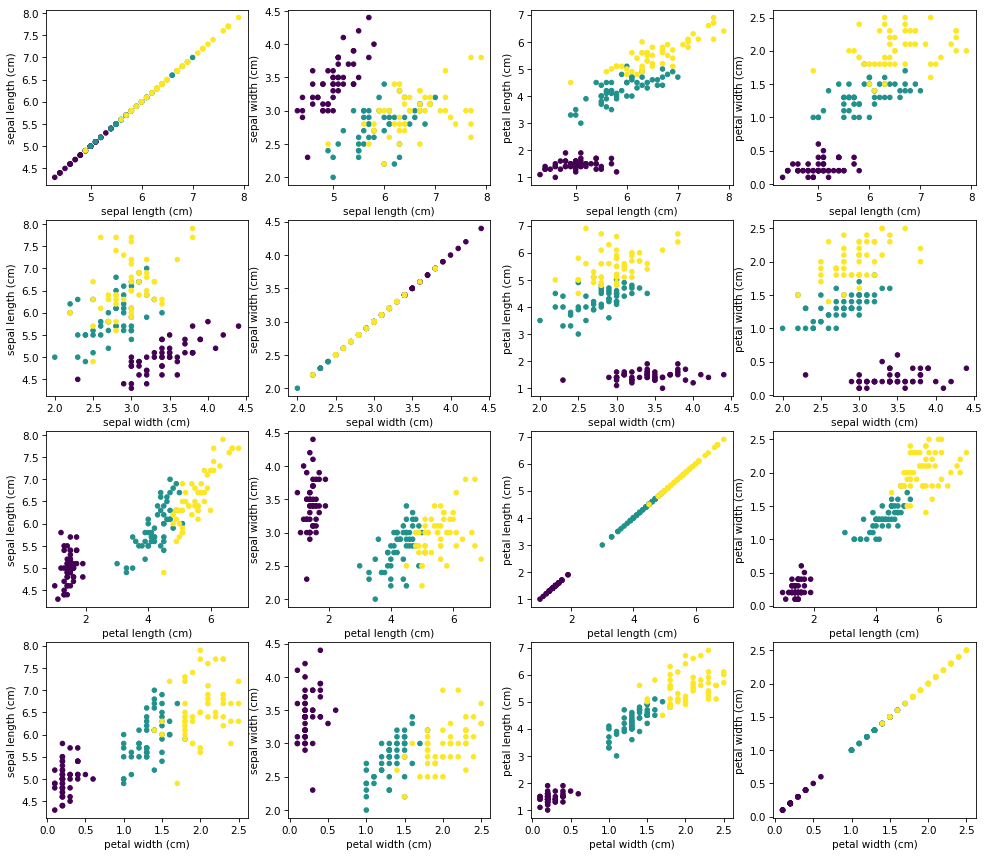

In [4]:
feature_names = iris.feature_names
X = iris.data
y = iris.target

plt.figure(figsize=(16, 14), dpi=75)
count = 0
for i in range(4):
    for j in range(4):
        plt.subplot(4, 4, count + 1)
        count += 1
        plt.scatter(X[:, i], X[:, j], c=y, marker='.', s=75)
        plt.xlabel(feature_names[i])
        plt.ylabel(feature_names[j])

In [5]:
Gaussian_kernel = lambda x: 1/(2*np.pi)**(1/2)*np.exp(-1/2*x**2)
Epanechnikov = lambda x: 3/4*(1-x**2)
Newton = lambda x: 1.0 / (x + 1)
Tri_cube = lambda x: (1 - x**3)**3

In [6]:
class PotentialFunctionsMethod():
    def __init__(self, kernel, h):
        self.Kernel = kernel
        self.h = h
        
        self.classes = None
        self.train_x = None
        self.train_y = None
        self.charges = None
        self.epoch_number = None
    
    def get_distance(self, x1, x2, p=2):
        return np.sum(((x1-x2) ** p), -1) ** (1/p)
    
    def fit(self, X_train, y_train, epoch_number):
        self.train_x = train_x
        self.train_y = train_y
        self.epoch_number = epoch_number
        self.classes = np.unique(train_y)
        self.charges = np.zeros_like(train_y)
        
        for _ in range(self.epoch_number):
            for i in range(self.train_x.shape[0]):
                if self.predict(self.train_x[i]) != self.train_y[i]:
                    self.charges[i] += 1
                    
        self.train_x = self.train_x[self.charges != 0]
        self.train_y = self.train_y[self.charges != 0]
        self.charges = self.charges[self.charges != 0]
        
    
    def predict(self, x_test: np.array):
        test_x = np.copy(x_test)
        if len(test_x.shape) < 2:
            test_x = test_x[np.newaxis, :]
        test_x1 = test_x[:, np.newaxis, :]
        train_x2 = self.train_x[np.newaxis, :, :]
        table = np.zeros((test_x.shape[0], len(self.classes)))
        
        weights = self.charges * self.Kernel(self.get_distance(test_x1, train_x2) / self.h)
        for class_ in self.classes:
            table[:, class_] = np.sum(weights[:, self.train_y == class_], axis=1)
        return np.argmax(table, axis=1)

In [7]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [8]:
c = list(zip(train_x, train_y))
np.random.shuffle(c)
train_x, train_y = zip(*c)
train_x = np.array(train_x)
train_y = np.array(train_y)
print(train_x)

[[4.4 3.2 1.3 0.2]
 [6.  2.2 4.  1. ]
 [5.8 4.  1.2 0.2]
 [7.7 2.8 6.7 2. ]
 [5.9 3.  5.1 1.8]
 [5.  3.4 1.5 0.2]
 [6.7 2.5 5.8 1.8]
 [6.4 2.8 5.6 2.1]
 [6.7 3.1 5.6 2.4]
 [6.7 3.1 4.4 1.4]
 [5.5 4.2 1.4 0.2]
 [5.4 3.  4.5 1.5]
 [5.8 2.7 5.1 1.9]
 [6.4 2.9 4.3 1.3]
 [6.5 3.2 5.1 2. ]
 [5.  3.5 1.3 0.3]
 [6.1 2.6 5.6 1.4]
 [6.4 3.2 5.3 2.3]
 [4.6 3.4 1.4 0.3]
 [6.3 2.9 5.6 1.8]
 [5.1 3.5 1.4 0.3]
 [6.1 2.8 4.7 1.2]
 [5.1 3.8 1.9 0.4]
 [7.7 3.  6.1 2.3]
 [5.5 2.5 4.  1.3]
 [5.7 2.9 4.2 1.3]
 [5.6 2.8 4.9 2. ]
 [6.6 2.9 4.6 1.3]
 [6.1 3.  4.9 1.8]
 [5.1 2.5 3.  1.1]
 [6.9 3.1 4.9 1.5]
 [4.3 3.  1.1 0.1]
 [6.  3.  4.8 1.8]
 [4.7 3.2 1.6 0.2]
 [5.4 3.9 1.3 0.4]
 [5.7 2.5 5.  2. ]
 [6.2 2.9 4.3 1.3]
 [6.5 3.  5.5 1.8]
 [6.2 2.2 4.5 1.5]
 [5.  3.  1.6 0.2]
 [5.2 3.4 1.4 0.2]
 [7.3 2.9 6.3 1.8]
 [7.2 3.2 6.  1.8]
 [6.3 3.4 5.6 2.4]
 [4.8 3.  1.4 0.1]
 [5.8 2.6 4.  1.2]
 [4.9 2.5 4.5 1.7]
 [6.2 3.4 5.4 2.3]
 [6.  2.2 5.  1.5]
 [5.9 3.2 4.8 1.8]
 [4.9 3.6 1.4 0.1]
 [5.1 3.3 1.7 0.5]
 [6.8 3.2 5.

In [9]:
potential_method = PotentialFunctionsMethod(Gaussian_kernel, 10)
potential_method.fit(train_x, train_y, 4)
print(potential_method.train_x.shape, potential_method.train_y.shape, potential_method.charges.shape)

(33, 4) (33,) (33,)


In [10]:
print(potential_method.charges)

[1 2 4 2 2 2 1 1 1 1 3 3 4 4 2 4 3 2 1 1 2 4 4 3 1 4 4 3 1 1 1 4 3]


In [11]:
predict = potential_method.predict(test_x)
print("accuracy = ", metrics.accuracy_score(test_y, predict))

accuracy =  0.7666666666666667


In [12]:
c = list(zip(train_x, train_y))
np.random.shuffle(c)
train_x, train_y = zip(*c)
train_x = np.array(train_x)
train_y = np.array(train_y)
print(train_x)

[[5.8 2.6 4.  1.2]
 [5.7 2.9 4.2 1.3]
 [4.9 2.5 4.5 1.7]
 [5.7 3.8 1.7 0.3]
 [7.6 3.  6.6 2.1]
 [5.5 2.5 4.  1.3]
 [6.7 3.  5.  1.7]
 [5.1 2.5 3.  1.1]
 [5.7 4.4 1.5 0.4]
 [5.5 3.5 1.3 0.2]
 [6.7 2.5 5.8 1.8]
 [5.7 2.5 5.  2. ]
 [6.7 3.1 4.4 1.4]
 [5.1 3.8 1.6 0.2]
 [6.1 2.6 5.6 1.4]
 [4.9 3.1 1.5 0.2]
 [6.  2.7 5.1 1.6]
 [6.  2.9 4.5 1.5]
 [4.8 3.4 1.6 0.2]
 [6.1 3.  4.9 1.8]
 [5.7 2.6 3.5 1. ]
 [6.4 3.2 5.3 2.3]
 [6.7 3.3 5.7 2.5]
 [7.9 3.8 6.4 2. ]
 [4.8 3.  1.4 0.3]
 [5.5 2.4 3.7 1. ]
 [5.  3.6 1.4 0.2]
 [5.2 4.1 1.5 0.1]
 [6.3 2.5 5.  1.9]
 [6.  3.  4.8 1.8]
 [5.8 2.8 5.1 2.4]
 [6.3 3.3 6.  2.5]
 [5.  3.  1.6 0.2]
 [4.7 3.2 1.6 0.2]
 [6.3 2.7 4.9 1.8]
 [5.8 4.  1.2 0.2]
 [6.  2.2 4.  1. ]
 [5.6 2.7 4.2 1.3]
 [5.2 3.5 1.5 0.2]
 [5.  2.3 3.3 1. ]
 [7.2 3.2 6.  1.8]
 [5.1 3.3 1.7 0.5]
 [5.8 2.7 3.9 1.2]
 [7.2 3.6 6.1 2.5]
 [6.4 2.8 5.6 2.1]
 [5.6 2.9 3.6 1.3]
 [6.1 2.8 4.7 1.2]
 [5.5 4.2 1.4 0.2]
 [6.1 2.9 4.7 1.4]
 [5.  3.5 1.3 0.3]
 [5.1 3.8 1.9 0.4]
 [5.3 3.7 1.5 0.2]
 [6.5 3.2 5.

In [13]:
potential_method = PotentialFunctionsMethod(Gaussian_kernel, 10)
potential_method.fit(train_x, train_y, 4)
print(potential_method.train_x.shape, potential_method.train_y.shape, potential_method.charges.shape)

(31, 4) (31,) (31,)


In [14]:
print(potential_method.charges)

[1 4 2 1 4 3 4 1 3 1 1 1 3 3 4 1 1 4 3 4 1 1 3 2 3 1 1 1 3 3 3]


In [15]:
predict = potential_method.predict(test_x)
print("accuracy = ", metrics.accuracy_score(test_y, predict))

accuracy =  1.0


In [22]:
N_epoch = 5
N_h = 20
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [28]:
# for epoch in range (1, N_epoch):
#     h_arr, acc = [], []
#     for h in range (1, N_h):
#         potential_method = PotentialFunctionsMethod(Gaussian_kernel, h)
#         potential_method.fit(train_x, train_y, epoch)
#         predict = potential_method.predict(test_x)
#         acc.append(metrics.accuracy_score(test_y, predict))
#         h_arr.append(h)
#     plt.plot(h_arr, acc, label=f"epoch {epoch}")
    
# plt.legend()
# plt.show()

In [24]:
kernels = [Gaussian_kernel,Epanechnikov,Newton,Tri_cube]
kernels = np.array(kernels)
windows = np.linspace(0.4, 20, num=79)

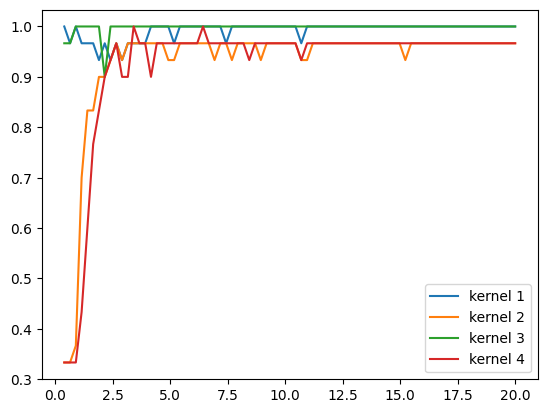

In [25]:
for kernel, i in zip(kernels, range(1,5)):
    h_arr, acc = [], []
    for h in windows:
        potential_method = PotentialFunctionsMethod(kernel, h)
        potential_method.fit(train_x, train_y, 4)
        predict = potential_method.predict(test_x)
        acc.append(metrics.accuracy_score(test_y, predict))
        h_arr.append(h)
#         print(i, "kernel:")
    plt.plot(h_arr, acc, label=f"kernel {i}")
    
plt.legend()
plt.show()

In [27]:
potential_method = PotentialFunctionsMethod(Newton, h=5)
potential_method.fit(train_x, train_y, 4)
predict = potential_method.predict(test_x)
print("accuracy = ", metrics.accuracy_score(test_y, predict))

accuracy =  1.0
